In [248]:
from ultralytics import YOLO 
import json
import Paths
import MyUtils
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [249]:
Path=Paths.ProjectPath()

In [250]:
model=YOLO(os.path.join(Path.Yolo_Training_Logs_Path,"resultx-2//weights//best.pt"))

In [251]:
dsfile=json.load(open(Path.DS_JsonFilePath,'r'))

In [139]:
model.nms=True

In [252]:
iou_matrix={}
ground={} #ground masks
prediction={} #predicted masks
ground_boxes={}
ground_conf={}
prediction_boxes={}
prediction_conf={}


Ground Truth Masks Obtained for: CSV_20180427_144513954.
Ground Truth Shape: (1536, 2048, 13)
Image File Detected as: CSV_20180427_144513954.jpg
Image shape: (1536, 2048, 3)
13 Ground Turth Boxes obtained for: CSV_20180427_144513954.

image 1/1 E:\vsc2.0\GitHub\Grape_instance_segementation_and_masking\PreprocessedDataset\Images\CSV_20180427_144513954.jpg: 480x640 16 Grapess, 1360.5ms
Speed: 5.0ms preprocess, 1360.5ms inference, 16.0ms postprocess per image at shape (1, 3, 480, 640)
Pred Masks Obtained for: CSV_20180427_144513954.
Pred Shape: (1536, 2048, 16)
Prediction Boxes obtained for: CSV_20180427_144513954.
IOU Matrix for masks obtained for CSV_20180427_144513954.
[[          0           0           0           0     0.72734           0           0           0           0           0           0           0           0           0           0           0]
 [          0     0.89309           0           0           0           0           0           0           0           0      

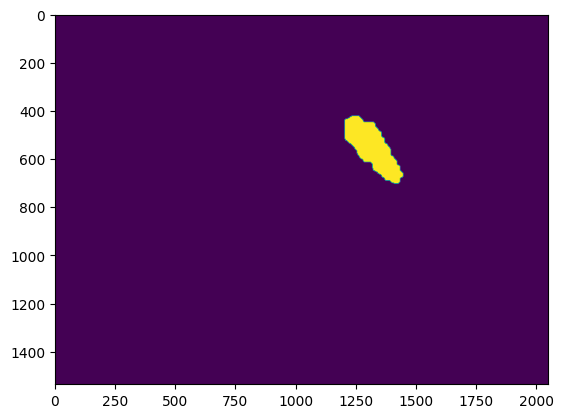

In [253]:
#obtaing groundtruths and corresponding yolo predcitions

for file in dsfile['test']:
    gt_truth=np.load(os.path.join(Path.DS_NPZMasksPath,file))
    gt_truth=gt_truth['arr_0']
    print("Ground Truth Masks Obtained for:",file[:-3])
    print("Ground Truth Shape:",gt_truth.shape)
    plt.imshow(gt_truth[:,:,0])

    textFile=open(os.path.join(Path.DS_TextFilesPath,file[:-3]+'txt'),'r')
    gt_boxes=textFile.readlines()
    gt_boxes_=[list(map(float,line.split(' ')))[1:] for line in gt_boxes ]
    gt_conf_=[1]*len(gt_boxes_)

    imgFile=file[:-3]+"jpg"
    print("Image File Detected as:",imgFile)
    img=cv2.imread(os.path.join(Path.DS_ImagesPath,imgFile))
    print("Image shape:",img.shape)

    height,width,_=img.shape

    ground_boxes[imgFile]=gt_boxes_
    ground_conf[imgFile]=gt_conf_
    print(len(gt_boxes_),"Ground Turth Boxes obtained for:",file[:-3])
    textFile.close()

    

    res=model.predict(os.path.join(Path.DS_ImagesPath,imgFile))
    pred=res[0].masks.data.numpy()
    n=pred.shape[0]

    pred_mask=np.zeros([height,width,n])

    for i in range(n):
        pred_mask[:,:,i]=cv2.resize(pred[i,:,:],[width,height])

    print("Pred Masks Obtained for:",file[:-3])
    print("Pred Shape:",pred_mask.shape)
    plt.imshow(pred_mask[:,:,0])

    prediction_boxes[imgFile]=res[0].boxes.xywhn.numpy()
    prediction_conf[imgFile]=res[0].boxes.conf.numpy()
    print("Prediction Boxes obtained for:",file[:-3])


    iou_matrix[imgFile]=MyUtils.compute_IOU_Matrix(gt_truth,pred_mask)
    ground[imgFile]=gt_truth
    prediction[imgFile]=pred_mask
    print("IOU Matrix for masks obtained for",file[:-3])
    print(iou_matrix[imgFile])

    

    



In [255]:
mIOU=MyUtils.compute_mIOU(iou_matrix)

In [256]:
print(mIOU)

0.6969478352051883


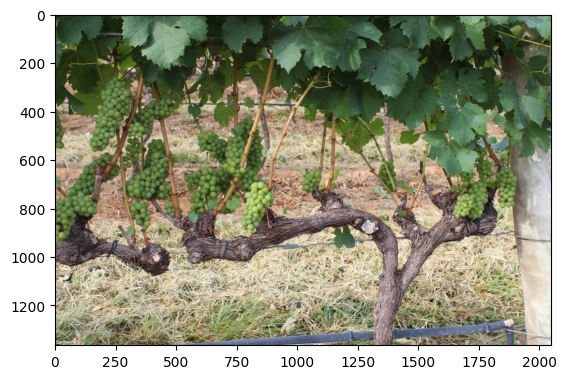

In [148]:
plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(Path.DS_ImagesPath,'CDY_2015.jpg')),cv2.COLOR_BGR2RGB))

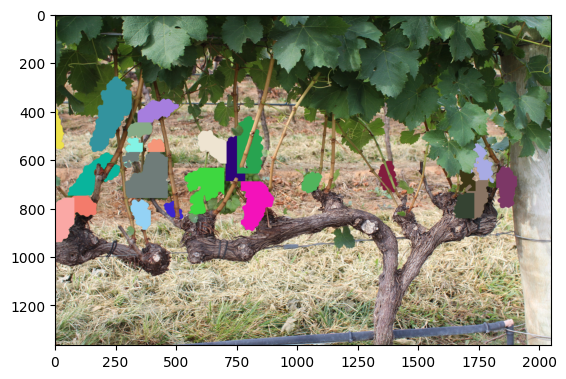

In [149]:
MyUtils.visualise(ground['CDY_2015.jpg'],'CDY_2015.jpg',imgPath=Path.DS_ImagesPath)

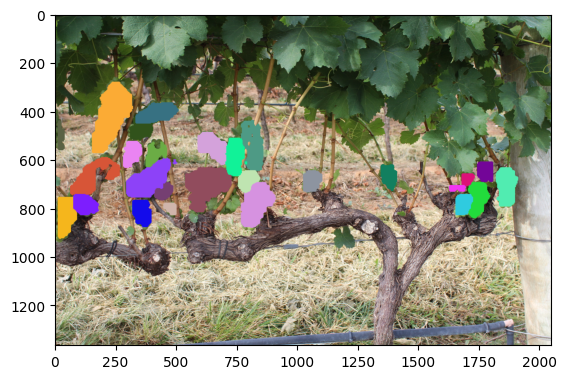

In [150]:
MyUtils.visualise(prediction['CDY_2015.jpg'],'CDY_2015.jpg',Path.DS_ImagesPath)

In [8]:
#MyUtils.visualise_with_boxes(ground['CDY_2015.jpg'],ground_boxes['CDY_2015.jpg'],ground_conf['CDY_2015.jpg'],'CDY_2015.jpg',Path.DS_ImagesPath)

In [9]:
#MyUtils.visualise_with_boxes(prediction['CDY_2015.jpg'],prediction_boxes['CDY_2015.jpg'],prediction_conf['CDY_2015.jpg'],'CDY_2015.jpg',Path.DS_ImagesPath)

In [5]:
#for key in ground:
    #MyUtils.visualise(ground[key],key,Path.DS_ImagesPath,Path.SG_GroundTruthImages_Path,save=True)

In [4]:
#for key in prediction:
    #MyUtils.visualise(prediction[key],key,Path.DS_ImagesPath,Path.SG_YoloPredictedImages_Path,True)

In [3]:
#for key in ground:
    #MyUtils.visualise_with_boxes(ground[key],ground_boxes[key],ground_conf[key],key,Path.DS_ImagesPath,Path.SG_GroundTruthImages_WithBoxes_Path,True)

In [2]:
#for key in ground:
    #MyUtils.visualise_with_boxes(prediction[key],prediction_boxes[key],prediction_conf[key],key,Path.DS_ImagesPath,Path.SG_YoloPredictedImages_WithBoxes_Path,True)
   # MyUtils.visualise_with_boxes(prediction[key],prediction_boxes[key],prediction_conf[key],key,Path.DS_ImagesPath,Path.SG_YoloPredictedImages_WithBoxes_Path,True,0.5)

In [1]:
# for key in ground:
#     height,width,_=cv2.imread(os.path.join(Path.DS_ImagesPath,key)).shape
#     display_instances(key,Path.DS_ImagesPath,np.array(convertYOLO_bb_2_MRCNN_bb(prediction_boxes[key],height,width)),prediction[key],np.ones((len(prediction_boxes[key])),dtype=np.int32),['Background','Grapes'],prediction_conf[key],save_dir=Path.SG_YoloPredictedImages_WithBoxes_Path,save=True)

In [257]:

mAP_list_mrcnn=[]
mAP_list_YOLO=[]
precisions_and_recalls={}
for key in ground:
    mAP_mrcnn, precisions, recalls, overlaps, precisions_org,recall_org=MyUtils.compute_ap_mrcnn(np.array(ground_boxes[key]),np.ones((len(ground_boxes[key]))),ground[key],prediction_boxes[key],np.ones((len(prediction_boxes[key]))),prediction_conf[key],prediction[key])
    mAP_YOLO,_,_= MyUtils.compute_ap_yolov8(recall_org,precisions_org)
    mAP_list_mrcnn.append(mAP_mrcnn)
    mAP_list_YOLO.append(mAP_YOLO)
    precisions_and_recalls[key]={'precisions':precisions,'recalls':recalls}
    
    print("mAP for",key,"is: ",mAP_YOLO)
    print("Average mAP till now is: ",sum(mAP_list_YOLO)/len(mAP_list_YOLO))


mAP for CSV_20180427_144513954.jpg is:  0.8919583365296324
Average mAP till now is:  0.8919583365296324
mAP for CDY_2015.jpg is:  0.8213936123260742
Average mAP till now is:  0.8566759744278534
mAP for CDY_2017.jpg is:  0.7553472222222222
Average mAP till now is:  0.8228997236926429
mAP for CDY_2018.jpg is:  0.7980666723132136
Average mAP till now is:  0.8166914608477855
mAP for CDY_20180427_153021423_BURST001.jpg is:  0.995
Average mAP till now is:  0.8523531686782284
mAP for CDY_20180427_153144437_BURST000_COVER_TOP.jpg is:  0.995
Average mAP till now is:  0.8761276405651904
mAP for CDY_2019.jpg is:  0.9223077036555031
Average mAP till now is:  0.882724792435235
mAP for CDY_2024.jpg is:  0.9325200028324129
Average mAP till now is:  0.8889491937348822
mAP for CDY_2028.jpg is:  0.8760428613986291
Average mAP till now is:  0.8875151568086319
mAP for CDY_2034.jpg is:  0.833386368091811
Average mAP till now is:  0.8821022779369498
mAP for CDY_2043.jpg is:  0.8410873370863341
Average mAP t

In [258]:
mAP_mrcnn=sum(mAP_list_mrcnn)/len(mAP_list_mrcnn)
mAP_YOLO=sum(mAP_list_YOLO)/len(mAP_list_YOLO)

In [259]:
print(mAP_mrcnn)
print(mAP_YOLO)

0.8399641424064834
0.8854281589660861


In [234]:
resultPath="E://vsc2.0//GitHub//Grape_instance_segementation_and_masking//ResultCurves"

In [241]:


def plot_PR_curve(precisions_and_recalls,mAP,save=False, save_dir=Path.ResultCurvesPath, saveFileName="PR_Curve.png",in_between_values=10000):
    """
    This function plots PR curve.

    precisions and recalls: A dictionary containing precision and recall arrays for each image in batch
                            {image:{precisions:[],recalls:[]}}
    mAP: mean AP for batch

    save: whether to save plot

    save_dir=which dir to save plot

    saveFileName=name by which plot needs to be saved

    in_between_values= Value distribution for interpolation
    """

    px=np.linspace(0,1,in_between_values)
    interpolated_ys=[]

    for key in precisions_and_recalls:
        precisions=precisions_and_recalls[key]['precisions']
        recalls=precisions_and_recalls[key]['recalls']
        f = interp1d(recalls,precisions, kind='linear', fill_value='interpolate')
        interpolated_y = f(px)
        interpolated_ys.append(interpolated_y)

    py = np.mean(interpolated_ys, axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(9, 6), tight_layout=True)

    ax.plot(px, py, linewidth=3, color="blue", label="Grapes %.3f mAP@0.5" % mAP)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    ax.set_title("Precision-Recall Curve for Grape Instance Segmentation")
    if save:
        save_dir=os.path.join(save_dir,saveFileName)
        fig.savefig(save_dir, dpi=250)
    plt.show()
    plt.close(fig)
    # if on_plot:
    #     on_plot(save_dir)



def plot_PrecisionConfidence_curve(scores,precisions,averagePrecisiion=0,save=False, save_dir=Path.ResultCurvesPath, saveFileName="PC_Curve.png",in_between_values=10000):
    """
    This function plots Precision-Confidence curve.

    scores: confidence array
    precisions: A dictionary containing precision array for each image in batch
                            
    averagePrecision: mean Precision for batch at confidence threshold 0.5

    save: whether to save plot

    save_dir=which dir to save plot

    saveFileName=name by which plot needs to be saved

     in_between_values= Value distribution for interpolation
    """

    px=np.linspace(0,1,in_between_values)
    interpolated_ys=[]

    for key in precisions:
        f = interp1d(scores,precisions[key], kind='linear', fill_value='extrapolate')
        interpolated_y = f(px)
        interpolated_ys.append(interpolated_y)

    py = np.mean(interpolated_ys, axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(9, 6), tight_layout=True)

    ax.plot(px, py, linewidth=3, color="blue", label="Grapes %.3f AveragePrecision@0.5" % averagePrecisiion)
    ax.set_xlabel("Confidence")
    ax.set_ylabel("Precision")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    ax.set_title("Precision-Confidence Curve for Grape Instance Segmentation")
    if save:
        save_dir=os.path.join(save_dir,saveFileName)
        fig.savefig(save_dir, dpi=250)
    plt.show()
    plt.close(fig)
    # if on_plot:
    #     on_plot(save_dir)


def plot_RecallConfidence_curve(scores,recalls,averageRecall=0,save=False, save_dir=Path.ResultCurvesPath, saveFileName="RC_Curve.png",in_between_values=10000):
    """
    This function plots Recall-Confidence curve.

    scores: confidence array
    recalls: A dictionary containing recall array for each image in batch
                            
    averageRecall: mean Recall for batch at confidence threshold 0.5

    save: whether to save plot

    save_dir=which dir to save plot

    saveFileName=name by which plot needs to be saved

     in_between_values= Value distribution for interpolation
    """

    px=np.linspace(0,1,in_between_values)
    interpolated_ys=[]

    for key in recalls:
        f = interp1d(scores,recalls[key], kind='linear', fill_value='extrapolate')
        interpolated_y = f(px)
        interpolated_ys.append(interpolated_y)
    # print("hello")
    py = np.mean(interpolated_ys, axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(9, 6), tight_layout=True)

    ax.plot(px, py, linewidth=3, color="blue", label="Grapes %.3f AverageRecall@0.5" % averageRecall)
    ax.set_xlabel("Confidence")
    ax.set_ylabel("Recall")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    ax.set_title("Recall-Confidence Curve for Grape Instance Segmentation")
    if save:
        save_dir=os.path.join(save_dir,saveFileName)
        fig.savefig(save_dir, dpi=250)
    plt.show()
    plt.close(fig)
    # if on_plot:
    #     on_plot(save_dir)


def plot_F1ScoreConfidence_curve(scores,F1Scores,averageF1=0,save=False, save_dir=Path.ResultCurvesPath, saveFileName="FC_Curve.png",in_between_values=10000):
    """
    This function plots F1-score-Confidence curve.

    scores: confidence array
    F1Scores: A dictionary containing F1-score array for each image in batch
                            
    averageF1: mean F1-Score for batch at confidence threshold 0.5

    save: whether to save plot

    save_dir=which dir to save plot

    saveFileName=name by which plot needs to be saved

     in_between_values= Value distribution for interpolation
    """

    px=np.linspace(0,1,in_between_values)
    interpolated_ys=[]

    for key in F1Scores:
        f = interp1d(scores,F1Scores[key], kind='linear', fill_value='interpolate')
        interpolated_y = f(px)
        interpolated_ys.append(interpolated_y)

    py = np.mean(interpolated_ys, axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(9, 6), tight_layout=True)

    ax.plot(px, py, linewidth=3, color="blue", label="Grapes %.3f Average_F1-Score@0.5" % averageF1)
    ax.set_xlabel("Confidence")
    ax.set_ylabel("F1-Score")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    ax.set_title("F1_Score-Confidence Curve for Grape Instance Segmentation")
    if save:
        save_dir=os.path.join(save_dir,saveFileName)
        fig.savefig(save_dir, dpi=250)
    plt.show()
    plt.close(fig)
    # if on_plot:
    #     on_plot(save_dir)


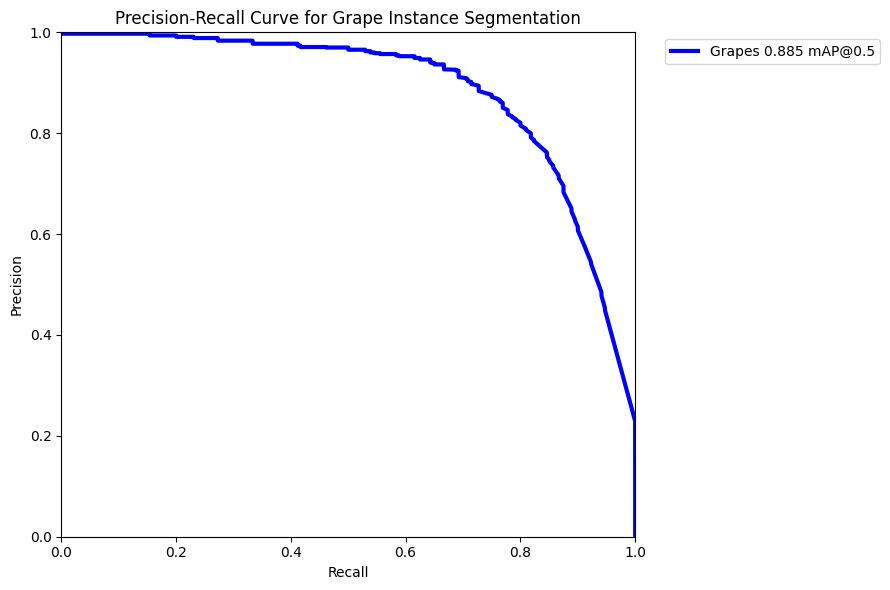

In [242]:
MyUtils.plot_PR_curve(precisions_and_recalls,mAP_YOLO,save=True,save_dir=resultPath,saveFileName="PR_curve_YOLOv8.png")

In [203]:
prediction_conf2={}
for key in ground:
    prediction_conf2[key]=np.max(iou_matrix[key],axis=1)

In [210]:

scores=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
precision_byConfidence={}
recall_byConfidence={}
F1Score_byConfidence={}


AveragePrecision=[]
AverageRecall=[]
AverageF1_Score=[]

for key in ground:
    precision_for_each_conf=[]
    recall_for_each_conf=[]
    f1_for_each_conf=[]
    for score in scores:
        _, _, _,_, precisions_array,recall_array=MyUtils.compute_ap_mrcnn(np.array(ground_boxes[key]),np.ones((len(ground_boxes[key]))),ground[key],prediction_boxes[key],np.ones((len(prediction_boxes[key]))),prediction_conf[key],prediction[key],my_score_threshold=score)
        if len(precisions_array)>0:
            precision_for_each_conf.append(precisions_array[-1])
        else:
            precision_for_each_conf.append(1)

        if len(recall_array)>0:
            recall_for_each_conf.append(recall_array[-1])
        else:
            recall_for_each_conf.append(0)

       # print(len(recall_for_each_conf))

    for h in range(0,11):
            f1_for_each_conf.append( (2*recall_for_each_conf[h]*precision_for_each_conf[h]) / (recall_for_each_conf[h]+precision_for_each_conf[h]) )


    print("Precision for",key,":",precision_for_each_conf)
    print("Recall for",key,":",recall_for_each_conf)
    print("F1-Score for",key,":",f1_for_each_conf)

    print()

    AveragePrecision.append(precision_for_each_conf[5])
    AverageRecall.append(recall_for_each_conf[5])
    AverageF1_Score.append(f1_for_each_conf[5])


    print("Till now Average Precision:",sum(AveragePrecision)/len(AveragePrecision),"Average Recall:",sum(AverageRecall)/len(AverageRecall),"Average F1-Score:",sum(AverageF1_Score)/len(AverageF1_Score))
    precision_byConfidence[key]=precision_for_each_conf
    recall_byConfidence[key]=recall_for_each_conf
    F1Score_byConfidence[key]=f1_for_each_conf
    print()
    
   

Precision for CSV_20180427_144513954.jpg : [0.6875, 0.6875, 0.6875, 0.7333333333333333, 0.8461538461538461, 0.9090909090909091, 1.0, 1.0, 1.0, 1, 1]
Recall for CSV_20180427_144513954.jpg : [0.84615386, 0.84615386, 0.84615386, 0.84615386, 0.84615386, 0.7692308, 0.7692308, 0.53846157, 0.46153846, 0, 0]
F1-Score for CSV_20180427_144513954.jpg : [0.7586206933405963, 0.7586206933405963, 0.7586206933405963, 0.7857142896676549, 0.8461538507388188, 0.8333333414047954, 0.8695652261798908, 0.700000023245811, 0.6315789495148487, 0.0, 0.0]

Till now Average Precision: 0.9090909090909091 Average Recall: 0.7692307829856873 Average F1-Score: 0.8333333414047954

Precision for CDY_2015.jpg : [0.6333333333333333, 0.6333333333333333, 0.6333333333333333, 0.6551724137931034, 0.7037037037037037, 0.6923076923076923, 0.72, 0.7727272727272727, 1.0, 1.0, 1]
Recall for CDY_2015.jpg : [0.7916667, 0.7916667, 0.7916667, 0.7916667, 0.7916667, 0.75, 0.75, 0.7083333, 0.5416667, 0.083333336, 0]
F1-Score for CDY_2015.jp

In [211]:
AvgPrecision=sum(AveragePrecision)/len(AveragePrecision)
AvgRecall=sum(AverageRecall)/len(AverageRecall)
AvgF1_score=sum(AverageF1_Score)/len(AverageF1_Score)

In [212]:
print("Average Precision:",AvgPrecision)
print("Average Recall:",AvgRecall)
print("Average F1-Score:",AvgF1_score)

Average Precision: 0.8090413614445588
Average Recall: 0.8440703371676003
Average F1-Score: 0.8216787838208809


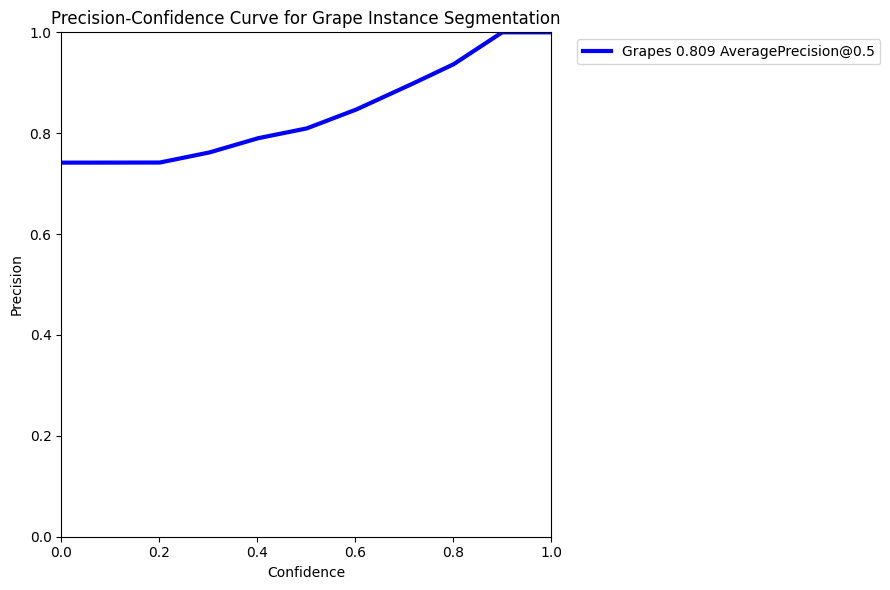

In [243]:
MyUtils.plot_PrecisionConfidence_curve(scores,precision_byConfidence,AvgPrecision,save=True,save_dir=resultPath,saveFileName="PrecisionConfidence_Curve_YOLOv8.png")

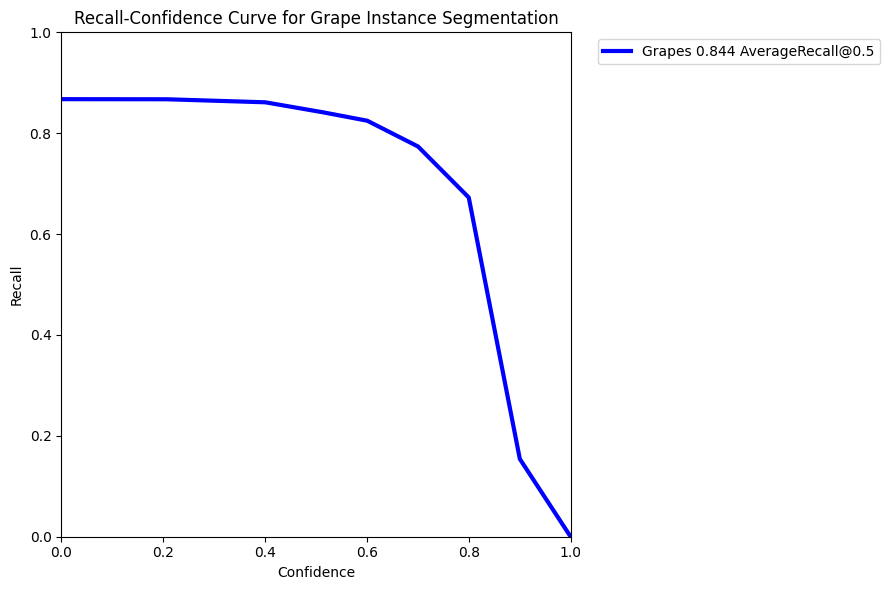

In [244]:
MyUtils.plot_RecallConfidence_curve(scores,recall_byConfidence,AvgRecall,save=True,save_dir=resultPath,saveFileName="RecallConfidence_Curve_YOLOv8.png")

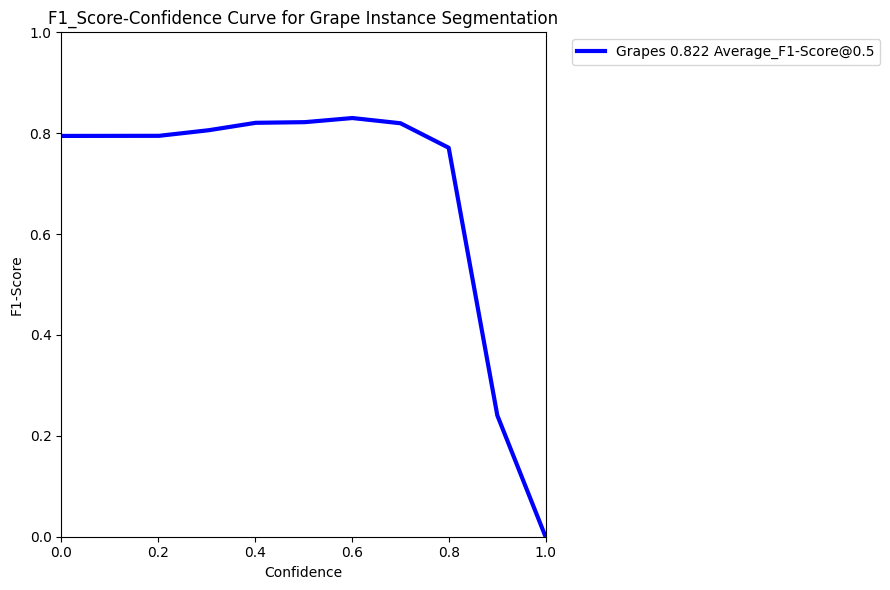

In [245]:
MyUtils.plot_F1ScoreConfidence_curve(scores,F1Score_byConfidence,AvgF1_score,save=True,save_dir=resultPath,saveFileName="F!ScoreConfidence_Curve_YOLOv8.png")